<a href="https://colab.research.google.com/github/helenpiepie/hl.github.io/blob/master/Amazon_Digital_Music_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering Recommendation: Amazon Digital Music

## Ingest

In [0]:
!pip install -q scikit-surprise

    100% |████████████████████████████████| 3.3MB 5.2MB/s 


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import seaborn as sns

import io
from surprise import SVD, KNNBasic
from surprise import Dataset
from surprise import evaluate, Reader
from surprise.model_selection import cross_validate

Data Source: http://jmcauley.ucsd.edu/data/amazon/links.html

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/helenpiepie/practice1/master/amazon_product.csv?token=ApqbMYZkQOeAZTNUcnXZNqaUexGxJZ8zks5cbFZ3wA%3D%3D")

In [0]:
df.head()

,Unnamed: 0,reviewID,productID,rating,unixReviewTime
0,1,A13HBXGVUGUT2R,5555991584,5,1373673600
1,2,A13QZGUU1PIJ4W,5555991584,5,1358208000
2,3,A14BTJRH9VNLJJ,5555991584,5,1375142400
3,4,A16KCH578FG4B4,5555991584,5,1044921600
4,5,A1878O39ZKG24F,5555991584,3,1371168000


In [0]:
df.drop(["unixReviewTime", "Unnamed: 0"], axis=1, inplace = True)
df.head()

,reviewID,productID,rating
0,A13HBXGVUGUT2R,5555991584,5
1,A13QZGUU1PIJ4W,5555991584,5
2,A14BTJRH9VNLJJ,5555991584,5
3,A16KCH578FG4B4,5555991584,5
4,A1878O39ZKG24F,5555991584,3


## EDA

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230392 entries, 0 to 230391
Data columns (total 3 columns):
reviewID     230392 non-null object
productID    230392 non-null object
rating       230392 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


### Rating Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


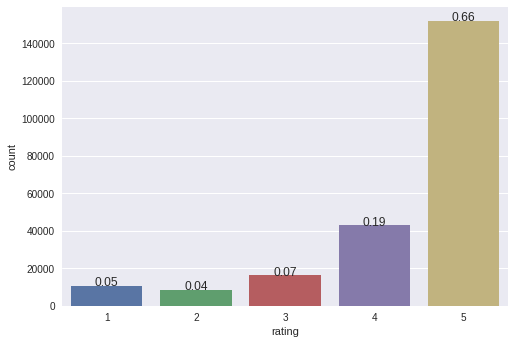

In [0]:
sns.set(style="darkgrid")
total = float(len(df)) # one person per row 

ax = sns.countplot(x="rating", data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
show()


### Rating by Product

In [0]:
df[['productID', 'rating']].groupby(["productID"])['rating'].size().nlargest(10)

productID
B0000AGWEC    1823
B000BGR18W    1386
B00008H2LB    1325
B00005YW4H    1282
B0007NFL18    1047
B000084T18     977
B00004T9UF     914
B00006690F     884
B00004XOWM     797
B000021YQV     778
Name: rating, dtype: int64

(array([1.663e+03, 1.052e+03, 7.090e+02, 4.720e+02, 3.850e+02, 2.890e+02,
        2.370e+02, 2.020e+02, 1.930e+02, 1.670e+02, 1.290e+02, 1.230e+02,
        1.010e+02, 8.100e+01, 8.300e+01, 6.200e+01, 6.600e+01, 5.200e+01,
        5.000e+01, 4.800e+01, 4.900e+01, 5.100e+01, 4.500e+01, 2.400e+01,
        3.200e+01, 3.100e+01, 3.600e+01, 2.900e+01, 2.400e+01, 2.100e+01,
        1.700e+01, 2.200e+01, 1.700e+01, 1.900e+01, 1.300e+01, 1.500e+01,
        1.000e+01, 1.000e+01, 1.700e+01, 1.500e+01, 8.000e+00, 1.000e+01,
        9.000e+00, 1.300e+01, 1.600e+01, 1.300e+01, 1.100e+01, 7.000e+00,
        6.000e+00, 7.000e+00, 5.000e+00, 5.000e+00, 7.000e+00, 9.000e+00,
        1.000e+01, 7.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 6.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 3.000e+00,
        7.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 8.000e+00,
        7.000e+00, 8.000e+00, 5.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        6.000e+00, 1.000e+00, 4.000e+0

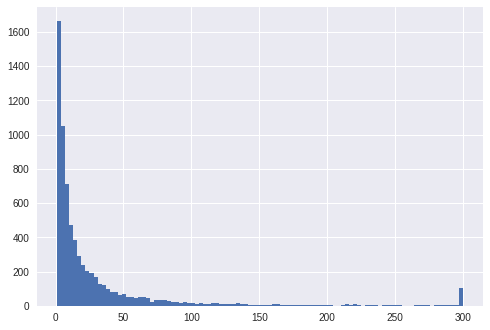

In [0]:
product_df = df[['productID', 'rating']].groupby(["productID"])['rating'].size().clip(upper = 300).reset_index(name="counts")
plt.hist(product_df["counts"], bins = 100)

### Rating by User

In [0]:
df[['reviewID', 'rating']].groupby(["reviewID"])['rating'].size().nlargest(10)

reviewID
A9Q28YTLYREO7     645
A3HU0B9XUEVHIM    392
A8IFUOL8S9BZC     310
A3C6ZCBUNXUT7V    278
A3KJ6JAZPH382D    229
A1GN8UJIZLCA59    227
A1J5KCZC8CMW9I    186
A3VZVYWCTGIEV0    176
A26NLSTT75FMJM    170
A3W0POMI33YQXQ    169
Name: rating, dtype: int64

(array([1.20273e+05, 1.41830e+04, 4.56500e+03, 2.20900e+03, 1.23700e+03,
        7.49000e+02, 5.36000e+02, 3.95000e+02, 2.87000e+02, 2.29000e+02,
        1.84000e+02, 1.30000e+02, 1.38000e+02, 9.50000e+01, 8.85000e+02]),
 array([ 1.        ,  1.93333333,  2.86666667,  3.8       ,  4.73333333,
         5.66666667,  6.6       ,  7.53333333,  8.46666667,  9.4       ,
        10.33333333, 11.26666667, 12.2       , 13.13333333, 14.06666667,
        15.        ]),
 <a list of 15 Patch objects>)

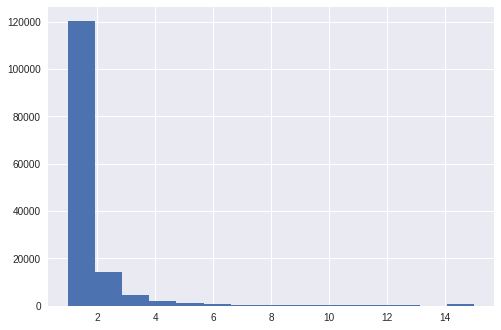

In [0]:
review_df = df[['reviewID', 'rating']].groupby(["reviewID"])['rating'].size().clip(upper = 15).reset_index(name="counts")
plt.hist(review_df["counts"], bins = 15)

## Modeling

### Load Dataset to Surprise

In [0]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['reviewID', 'productID', 'rating']], reader)

In [0]:
data

In [0]:
trainset = data.build_full_trainset()

### Train SVD Model - Predict User's Rating of Product

In [0]:
algo = SVD()
evaluate(algo, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9842
MAE:  0.7144
------------
Fold 2
RMSE: 0.9895
MAE:  0.7154
------------
Fold 3
RMSE: 0.9965
MAE:  0.7190
------------
Fold 4
RMSE: 0.9929
MAE:  0.7210
------------
Fold 5
RMSE: 1.0032
MAE:  0.7240
------------
------------
Mean RMSE: 0.9933
Mean MAE : 0.7188
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7144285945659898,
                             0.7154416015818499,
                             0.7189827442073338,
                             0.7210470872308603,
                             0.7239650687241148],
                            'rmse': [0.9842116977472333,
                             0.9894722866292864,
                             0.9965466589172934,
                             0.9929070703054447,
                             1.0031643473257283]})

In [0]:
algo.train(trainset)

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Afterwards to predict a rating we give the reviewID, productID and the actual rating as follows

In [0]:
# we can now query for specific predicions
uid = "A13HBXGVUGUT2R"  # raw user id
pid = "5555991584"  # raw product id

# get a prediction for specific users and items.
pred = algo.predict(uid, pid, r_ui=5, verbose=True)


user: A13HBXGVUGUT2R item: 5555991584 r_ui = 5.00   est = 4.69   {'was_impossible': False}


### Train KNN Basic Model - Recommend Similar Product 

In [0]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
sim_algo = KNNBasic(sim_options=sim_options)

In [0]:
sim_algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Recommend 10 similar products with product "5555991584"

In [0]:
pid = "5555991584"
inner_id = sim_algo.trainset.to_inner_iid(pid)
product_neighbor = sim_algo.get_neighbors(inner_id, k=10)
product_neighbor = (sim_algo.trainset.to_raw_iid(inner)
                       for inner in product_neighbor)
for product in product_neighbor:
  print(product)

B00000016T
B0000004VW
B0000004XH
B00000053X
B00000064E
B000000ECX
B000000HRS
B000000OME
B000000OPC
B000000OQL


## Conclusion





*   The idea behind collaborative filtering is to recommend new items based on the similarity of users. Surprise is a handy and powerful Python library for simple recommendation systems to perform item-item collaborative filtering. Besides cosine similarity, we can also use Pearson or MSD as similarity measures. 
*   I would recommend using collaborative filtering to identify similar users and learn about their favorites. Then we can provide a recommendation list of new digital music to users. By tracking whether users accept the recommendation and listen to the music, we have more information of users’ likes and dislikes. Understanding users and making right recommendations are important to maintain customers.

